In [9]:
from pathlib import Path
root = Path().resolve().parent.parent
root

PosixPath('/Users/gregruyoga/gmoneycodes/gmsm')

Loading backtest results...
Results directory: /Users/gregruyoga/gmoneycodes/gmsm/results

STRATEGY COMPARISON
shape: (4, 13)
┌────────────┬──────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ config     ┆ strategy ┆ threshold ┆ maturity ┆ … ┆ win_rate  ┆ best_trad ┆ worst_tra ┆ sharpe_ra │
│ ---        ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---       ┆ e         ┆ de        ┆ tio       │
│ str        ┆ str      ┆ f64       ┆ str      ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│            ┆          ┆           ┆          ┆   ┆           ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Conservati ┆ straddle ┆ 0.03      ┆ 1M       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ ve_1M_Stra ┆          ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ ddles      ┆          ┆           ┆          ┆   ┆           ┆  

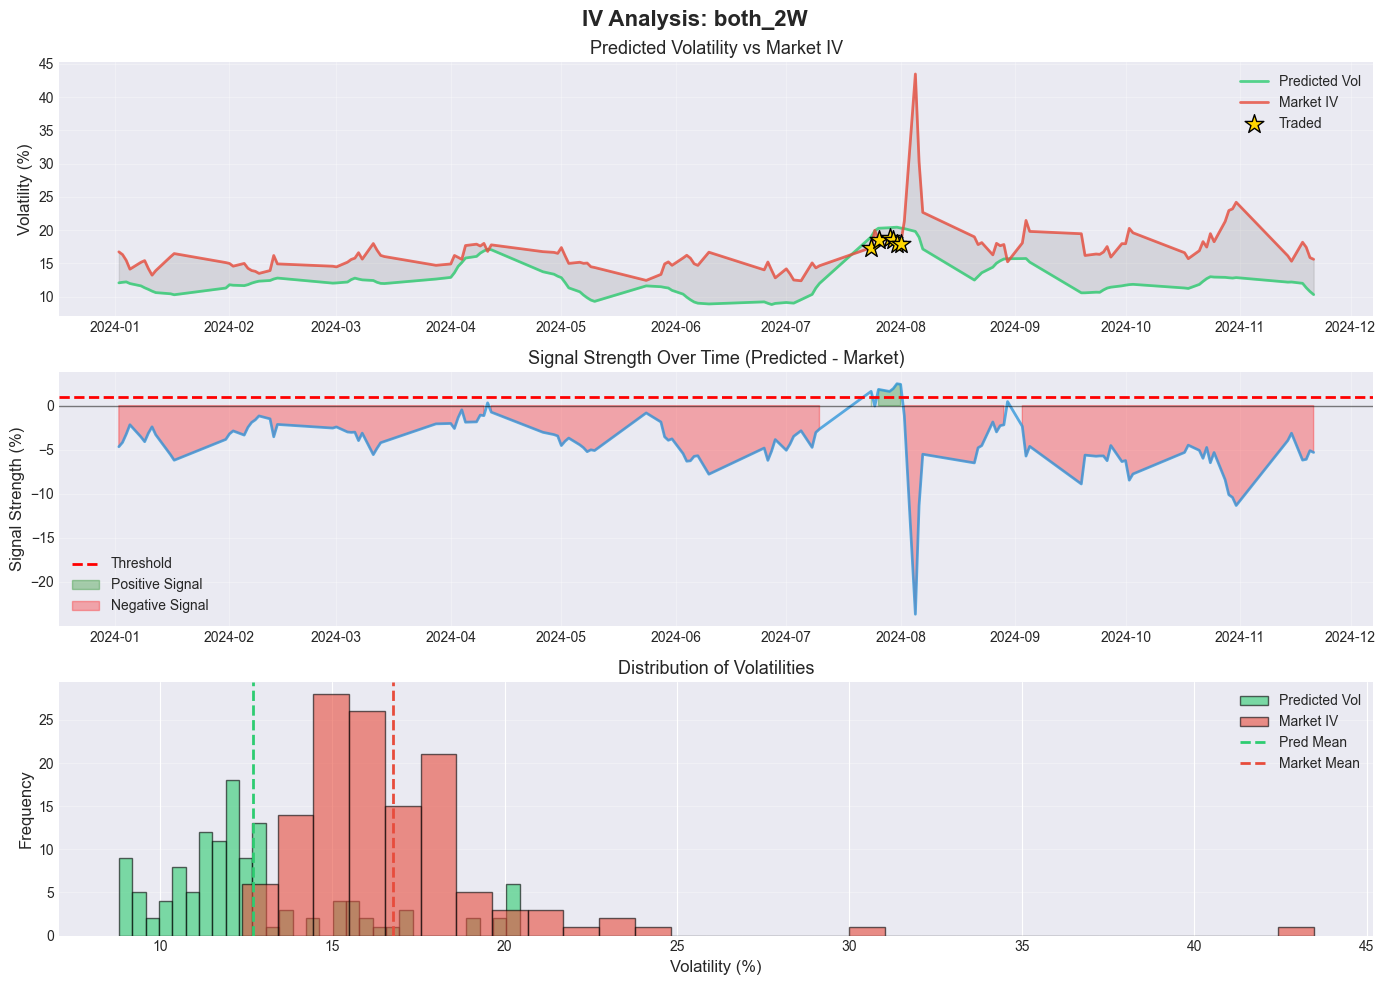


IV STATISTICS: both_2W
Predicted Vol:  12.70% ± 2.85%
Market IV:      16.75% ± 3.49%
Signal Strength: -4.05% ± 3.09%
Correlation:    0.541

Signal Distribution:
  Positive signals: 8 (6.3%)
  Above threshold:  6 (4.7%)
  Days traded:      6 (4.7%)


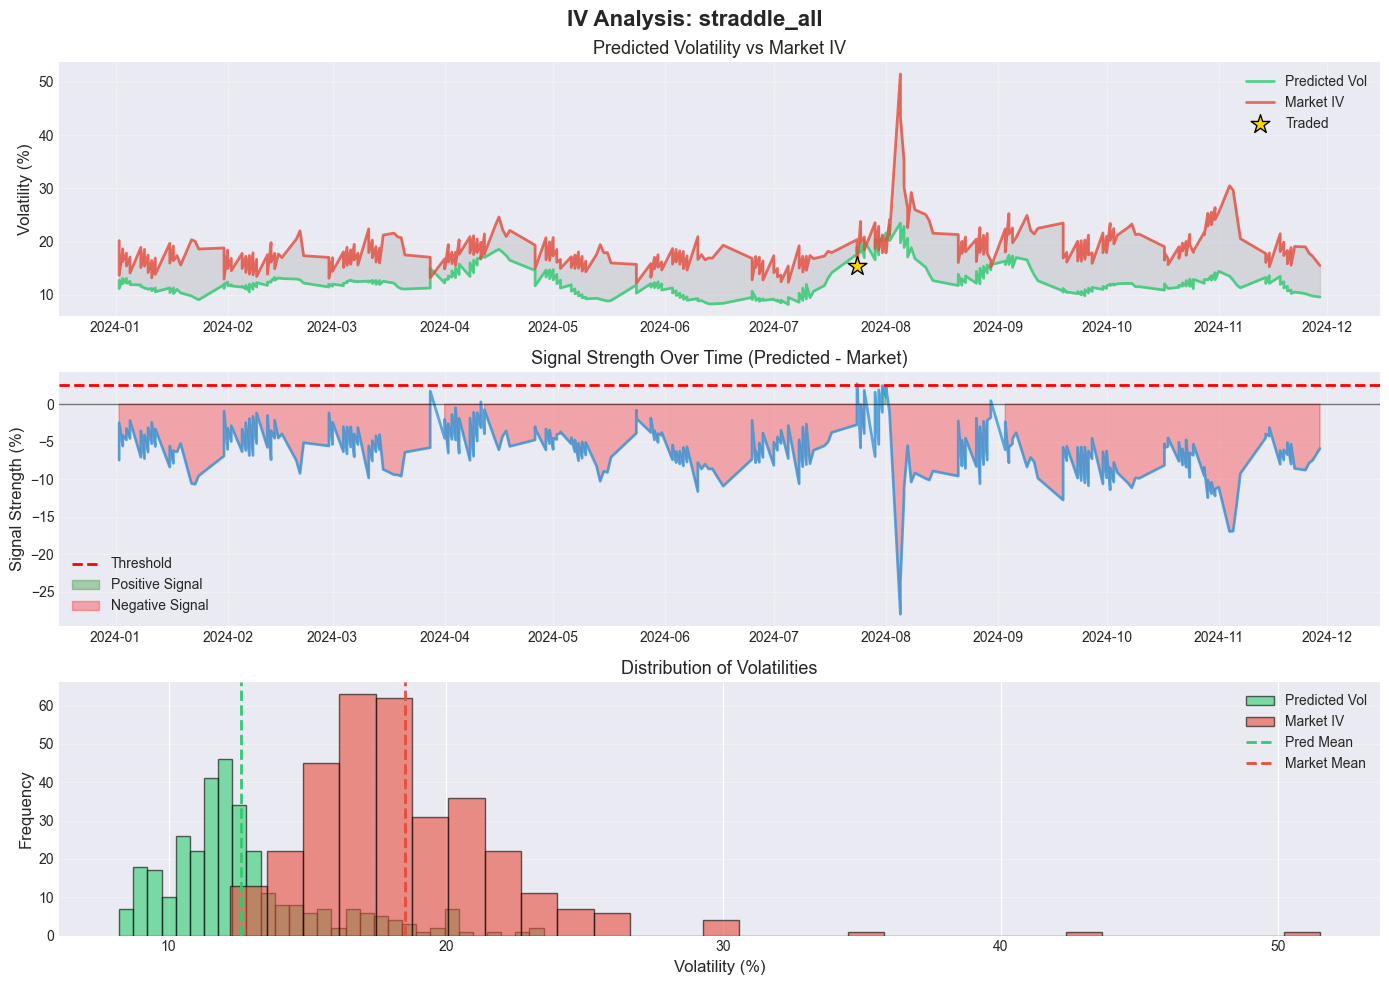


IV STATISTICS: straddle_all
Predicted Vol:  12.61% ± 2.87%
Market IV:      18.54% ± 4.04%
Signal Strength: -5.93% ± 3.51%
Correlation:    0.528

Signal Distribution:
  Positive signals: 11 (3.4%)
  Above threshold:  1 (0.3%)
  Days traded:      1 (0.3%)


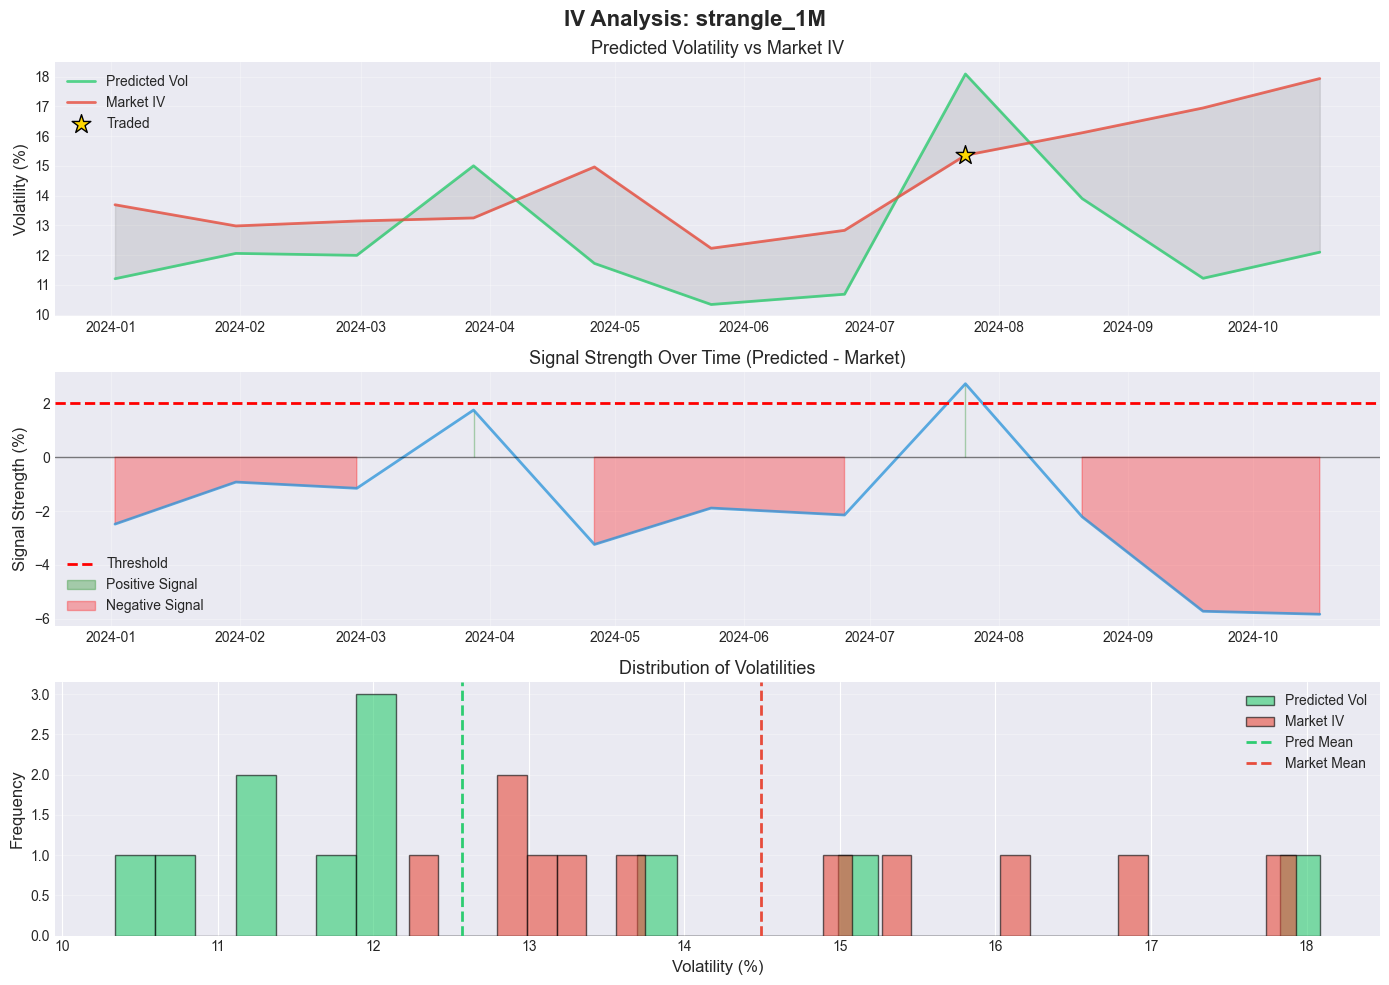


IV STATISTICS: strangle_1M
Predicted Vol:  12.57% ± 2.28%
Market IV:      14.49% ± 1.89%
Signal Strength: -1.92% ± 2.62%
Correlation:    0.218

Signal Distribution:
  Positive signals: 2 (18.2%)
  Above threshold:  1 (9.1%)
  Days traded:      1 (9.1%)


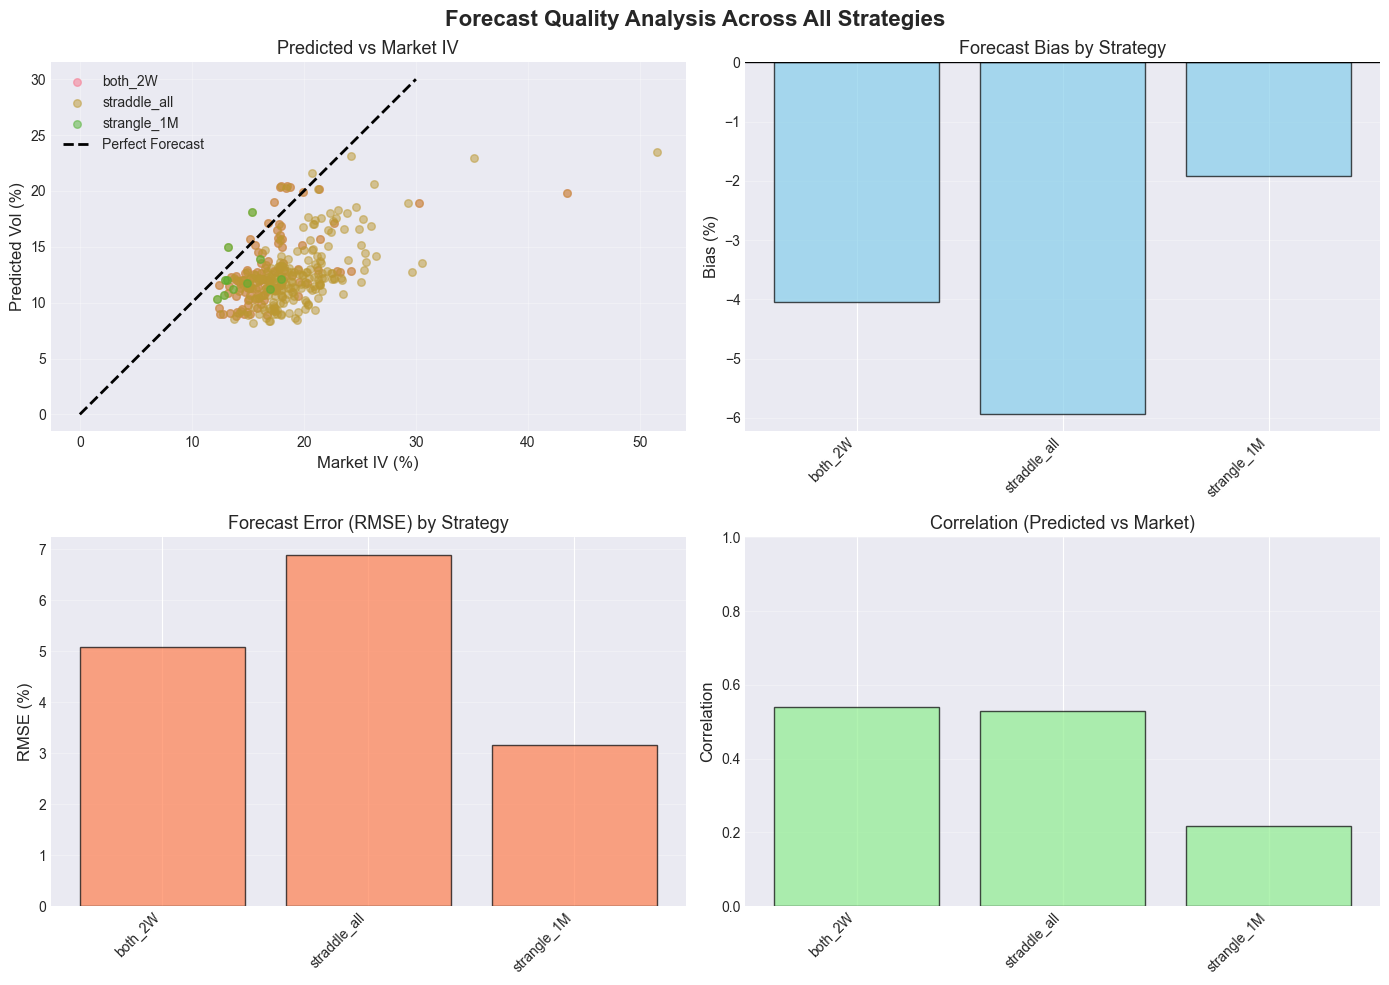


FORECAST QUALITY METRICS
    strategy      bias      mae     rmse  correlation
     both_2W -4.047731 4.247534 5.085450     0.540936
straddle_all -5.926617 6.038121 6.886170     0.527969
 strangle_1M -1.920326 2.735437 3.151408     0.218197


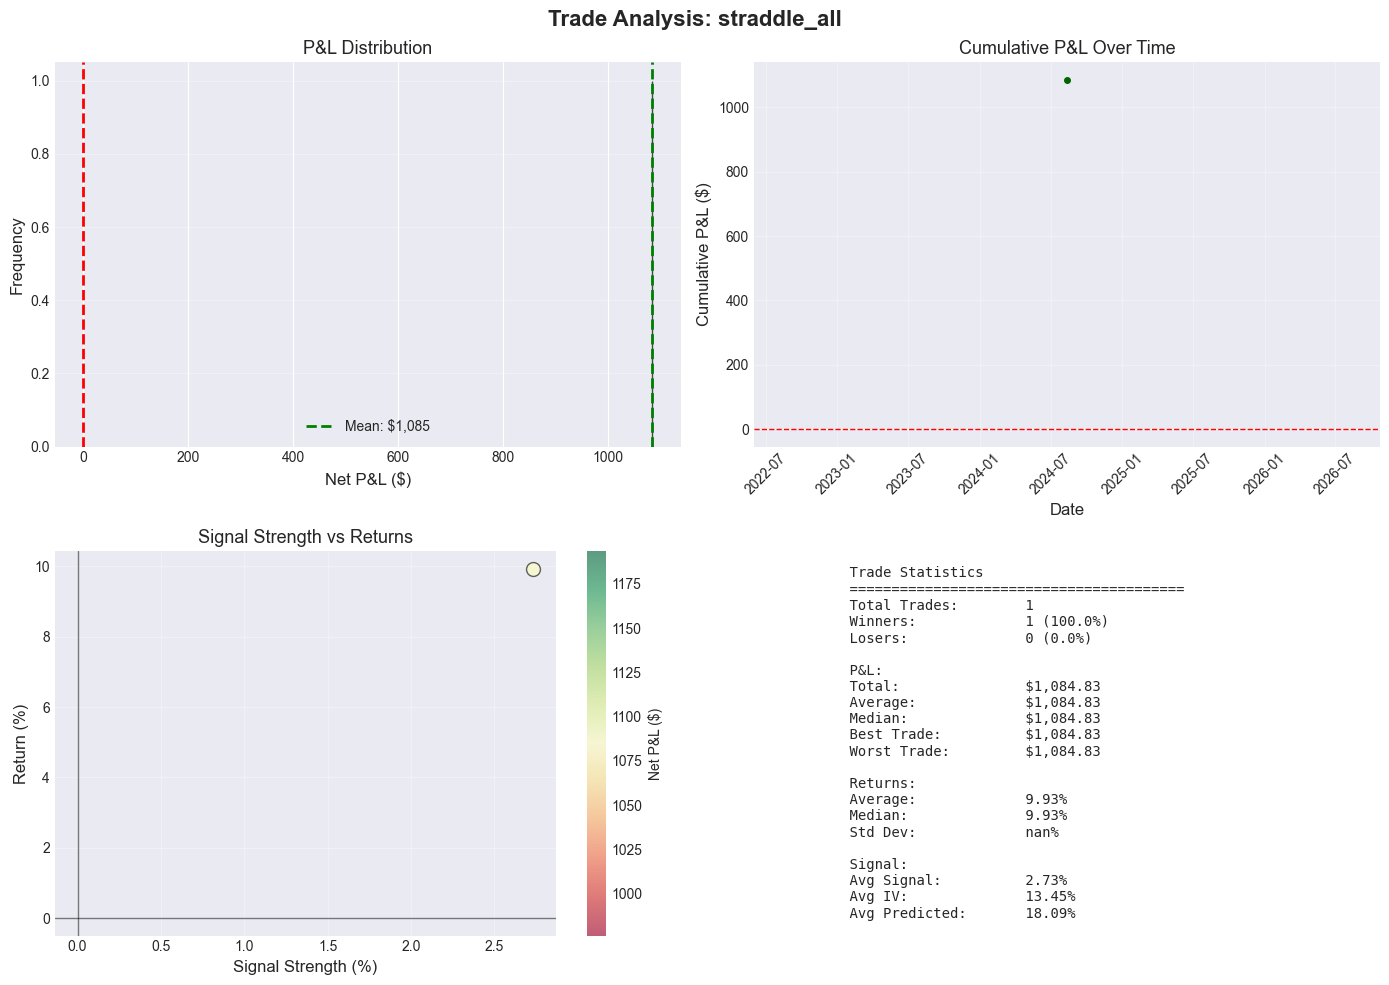

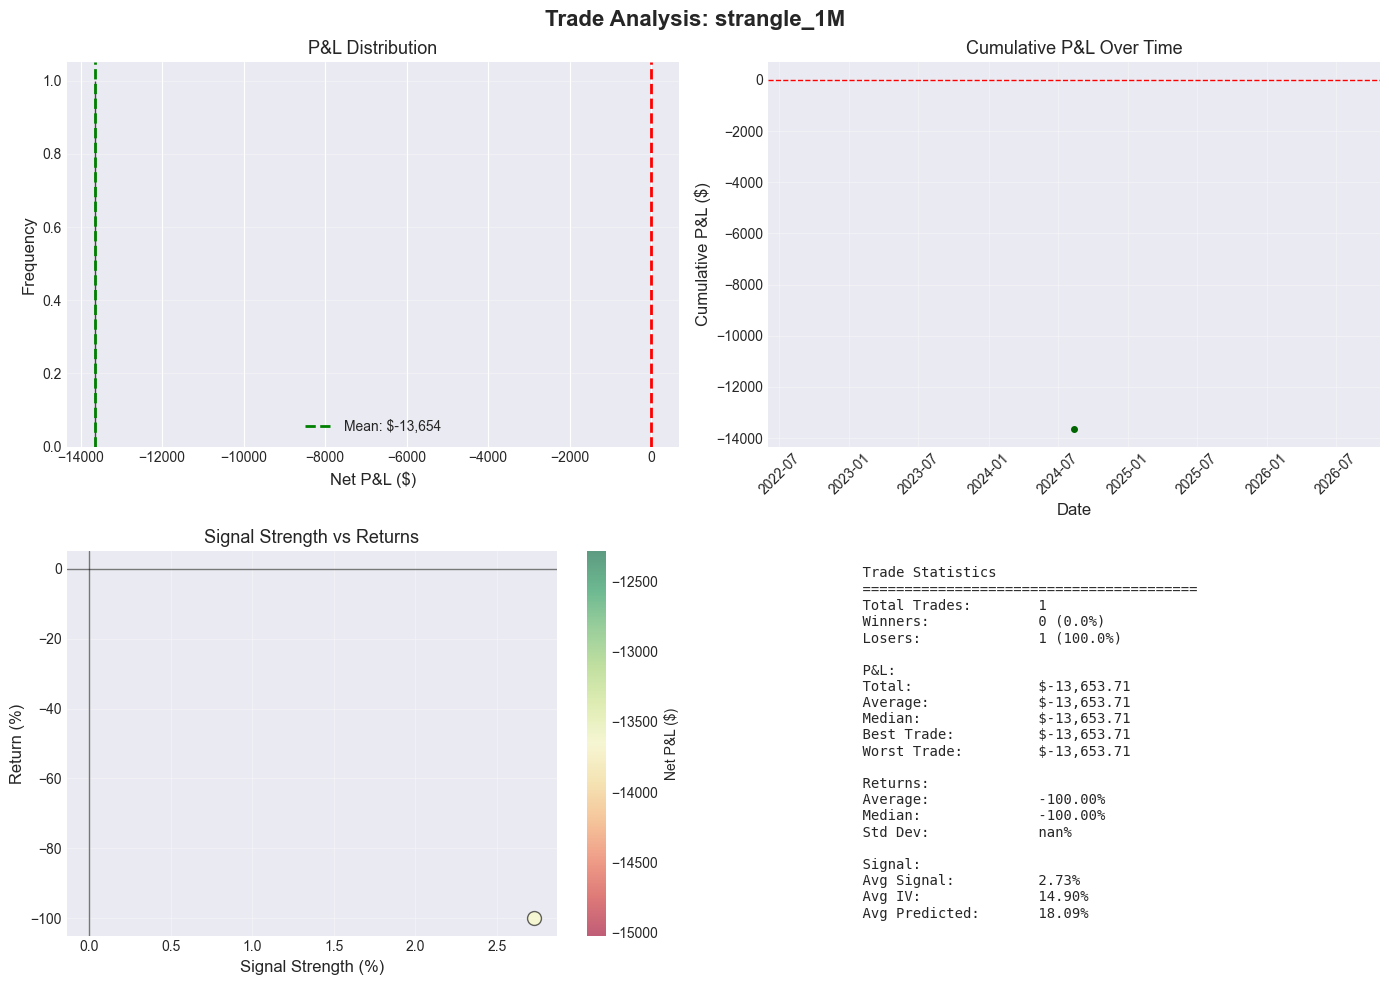

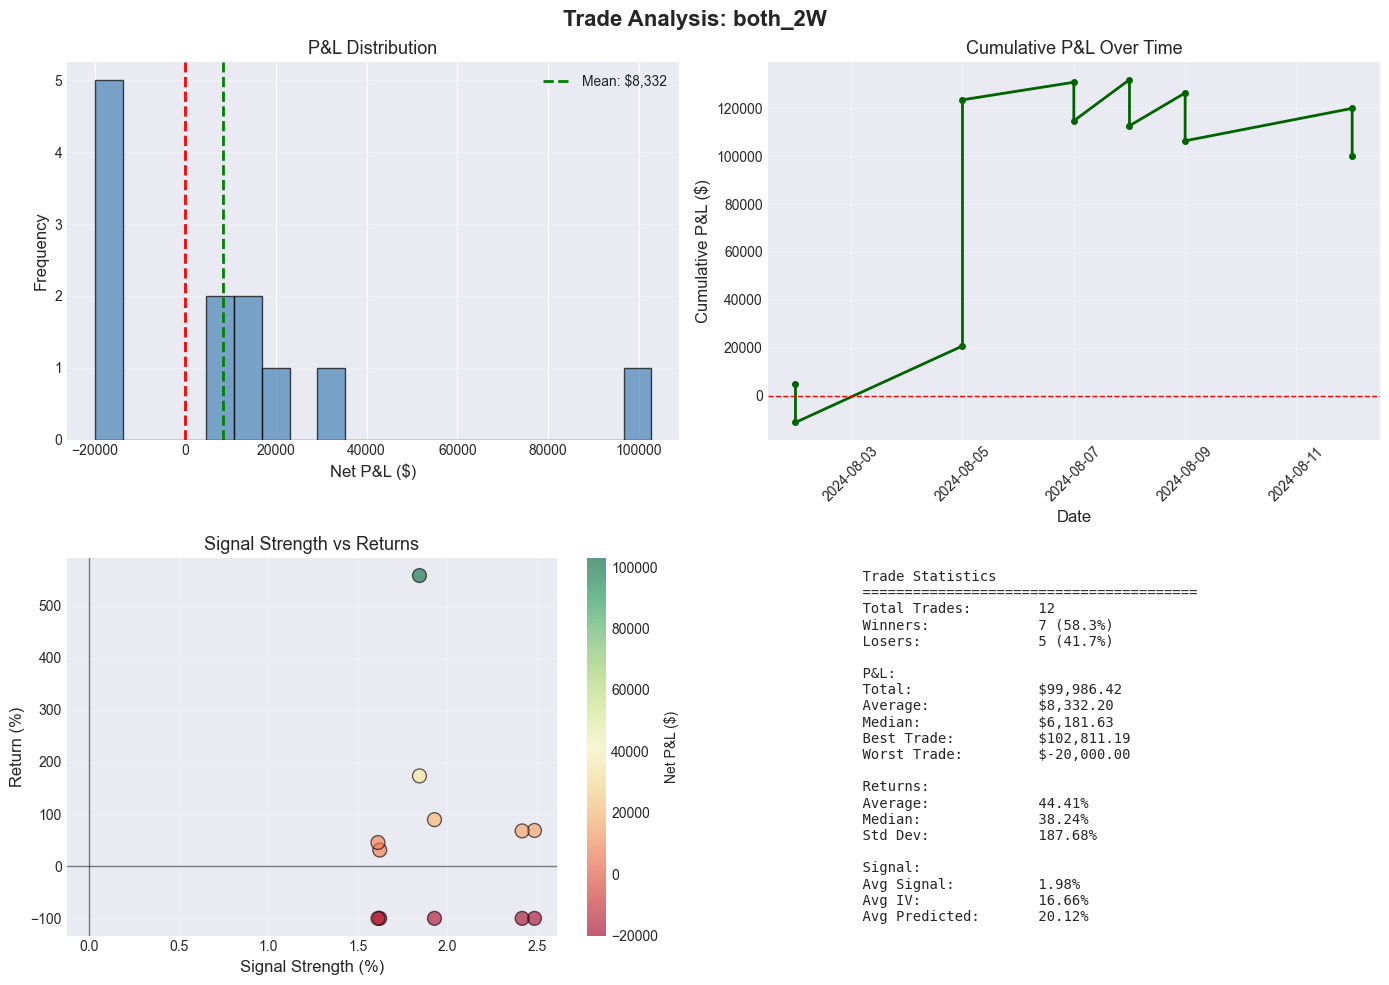

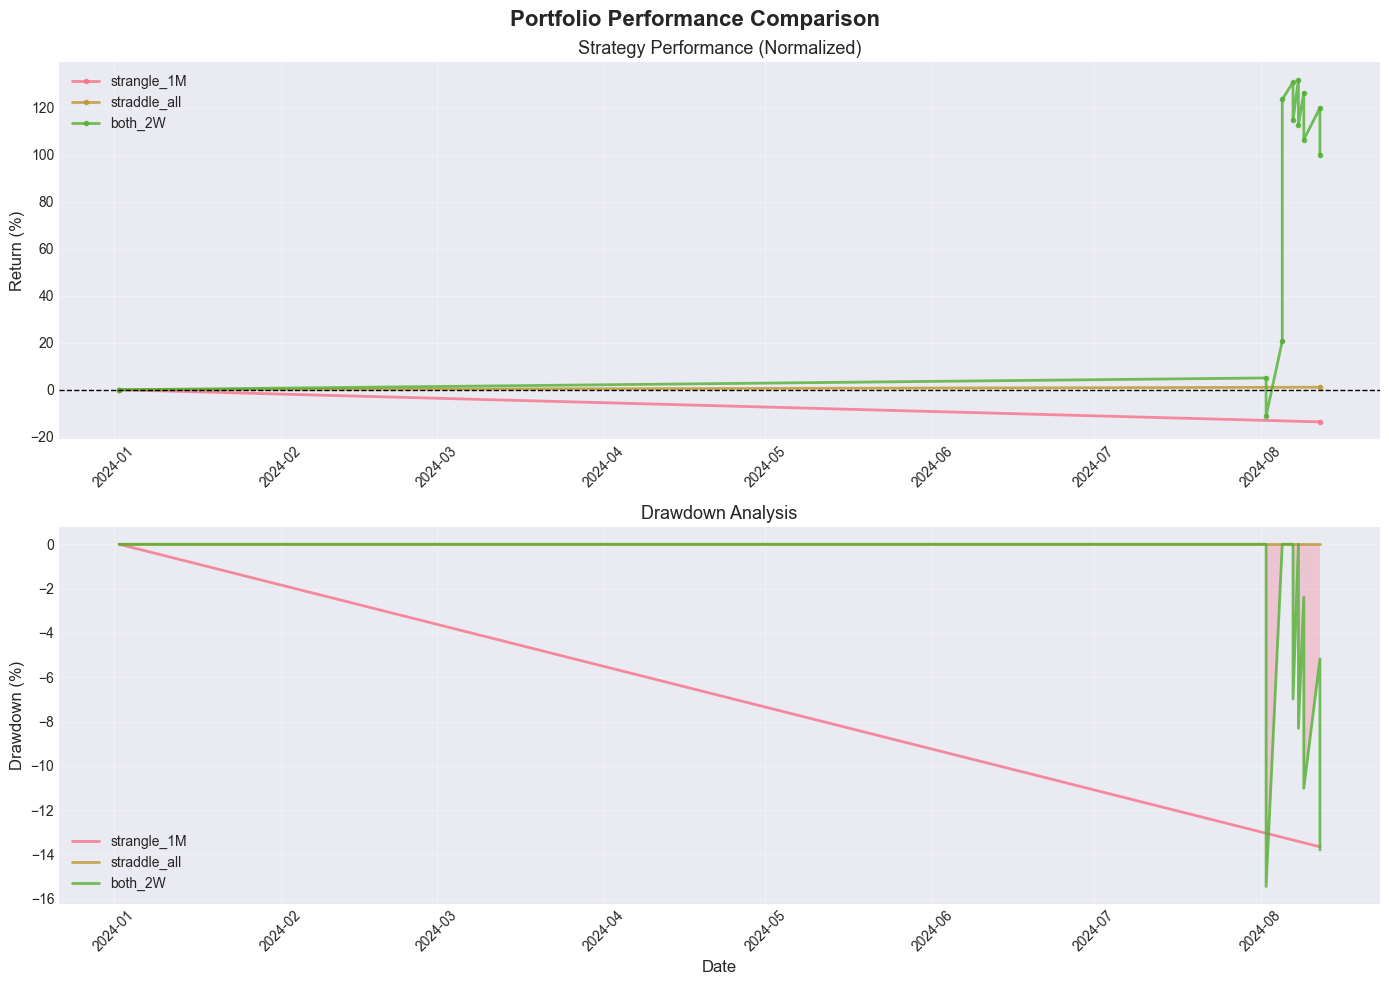

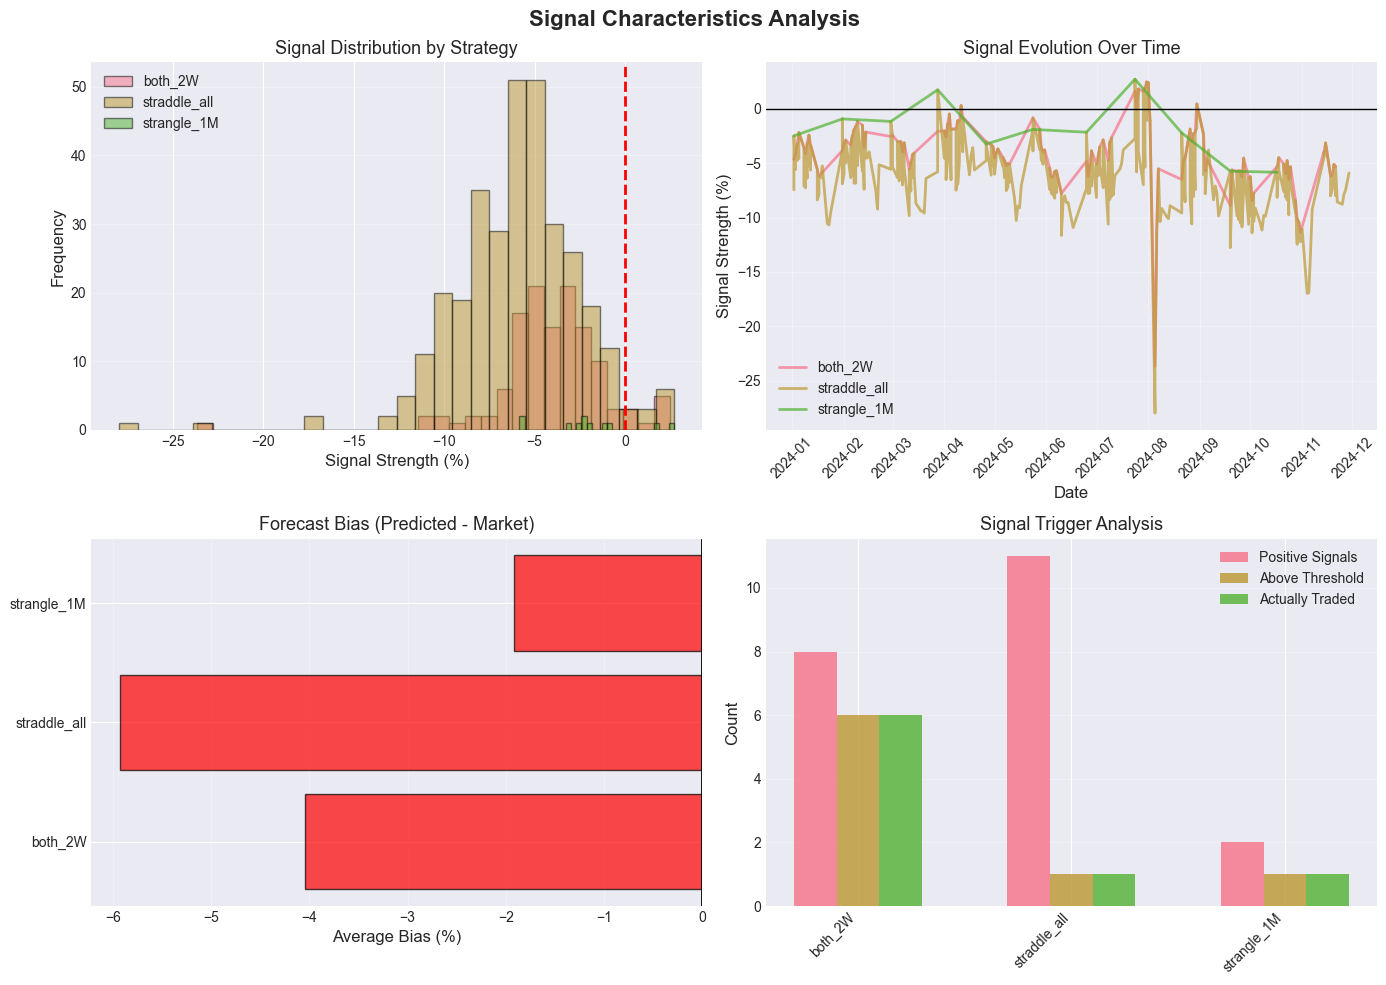


SIGNAL TRIGGER ANALYSIS
    Strategy  Total Days  Positive Signals  Above Threshold  Traded
     both_2W         127                 8                6       6
straddle_all         325                11                1       1
 strangle_1M          11                 2                1       1

KEY INSIGHTS & RECOMMENDATIONS

1. FORECAST BIAS:
   Your model consistently predicts LOWER volatility than market
   - both_2W: -4.05% average bias
   - straddle_all: -5.93% average bias
   - strangle_1M: -1.92% average bias

   → IMPLICATION: Market IV > Predicted most of the time
   → This means you rarely get long signals (need predicted > market)

2. SIGNAL FREQUENCY:
   - both_2W:
     Positive signals: 6.3%
     Above threshold: 4.7%
   - straddle_all:
     Positive signals: 3.4%
     Above threshold: 0.3%
   - strangle_1M:
     Positive signals: 18.2%
     Above threshold: 9.1%

   → IMPLICATION: Very few trading opportunities
   → Consider: Lower threshold or add short volatility stra

In [12]:
"""
Backtest Results Analysis Notebook
===================================
Comprehensive visualization and analysis of options backtesting results
"""

# %% [markdown]
# # Options Backtest Analysis
#
# This notebook analyzes the results from your MDSV volatility forecasting backtest.
#
# ## Key Findings from Results:
# - Best Strategy: Aggressive_2W_Both (99.99% return, 58.3% win rate)
# - Signal Analysis: Mostly negative signals (93.7% of time predicted < market)
# - Low Trading Frequency: Only 4.7% of days had tradeable signals
#
# Let's dive deeper into the data...

# %%
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %%
# Configuration
RESULTS_DIR = root / 'results'
OUTPUT_DIR = root / 'results' / 'analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

print("Loading backtest results...")
print(f"Results directory: {RESULTS_DIR}")

# %% [markdown]
# ## 1. Load All Results

# %%
# Load comparison summary
comparison_df = pl.read_csv(RESULTS_DIR / 'backtest_comparison.csv')
print("\n" + "="*70)
print("STRATEGY COMPARISON")
print("="*70)
print(comparison_df)

# %%
# Load IV data for each strategy
iv_files = list(RESULTS_DIR.glob('iv_data_*.csv'))
print(f"\nFound {len(iv_files)} IV data files")

iv_data = {}
for iv_file in iv_files:
    strategy_name = iv_file.stem.replace('iv_data_', '')
    df = pl.read_csv(str(iv_file))
    iv_data[strategy_name] = df
    print(f"  {strategy_name}: {len(df)} data points")

# %%
# Load trade data
trade_files = list(RESULTS_DIR.glob('trades_*.csv'))
print(f"\nFound {len(trade_files)} trade files")

trade_data = {}
for trade_file in trade_files:
    strategy_name = trade_file.stem.replace('trades_', '')
    try:
        df = pl.read_csv(str(trade_file))
        if len(df) > 0:
            trade_data[strategy_name] = df
            print(f"  {strategy_name}: {len(df)} trades")
    except:
        print(f"  {strategy_name}: No trades or error loading")

# %%
# Load equity curves
equity_files = list(RESULTS_DIR.glob('equity_*.csv'))
print(f"\nFound {len(equity_files)} equity files")

equity_data = {}
for equity_file in equity_files:
    strategy_name = equity_file.stem.replace('equity_', '')
    df = pl.read_csv(str(equity_file))
    equity_data[strategy_name] = df
    print(f"  {strategy_name}: {len(df)} data points")

# %% [markdown]
# ## 2. Market IV vs Predicted Volatility Analysis

# %%
def plot_iv_comparison(strategy_name, iv_df):
    """Plot predicted volatility vs market IV for a strategy"""

    # Convert to pandas for easier plotting
    df = iv_df.to_pandas()
    df['date'] = pd.to_datetime(df['date'])

    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(f'IV Analysis: {strategy_name}', fontsize=16, fontweight='bold')

    # Plot 1: Time series of predicted vs market IV
    ax1 = axes[0]
    ax1.plot(df['date'], df['predicted_vol'] * 100, label='Predicted Vol',
             linewidth=2, alpha=0.8, color='#2ecc71')
    ax1.plot(df['date'], df['market_iv'] * 100, label='Market IV',
             linewidth=2, alpha=0.8, color='#e74c3c')

    # Shade area between curves
    ax1.fill_between(df['date'],
                     df['predicted_vol'] * 100,
                     df['market_iv'] * 100,
                     alpha=0.2, color='gray')

    # Mark traded days
    if 'traded' in df.columns:
        traded_days = df[df['traded']]
        if len(traded_days) > 0:
            ax1.scatter(traded_days['date'], traded_days['market_iv'] * 100,
                       marker='*', s=200, color='gold', edgecolor='black',
                       label='Traded', zorder=5)

    ax1.set_ylabel('Volatility (%)', fontsize=12)
    ax1.set_title('Predicted Volatility vs Market IV', fontsize=13)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Signal strength over time
    ax2 = axes[1]
    ax2.plot(df['date'], df['signal_strength'] * 100,
             linewidth=2, color='#3498db', alpha=0.8)
    ax2.axhline(y=df['threshold'].iloc[0] * 100, color='red',
                linestyle='--', linewidth=2, label='Threshold')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Shade positive signals
    positive_signal = df['signal_strength'] > 0
    ax2.fill_between(df['date'], 0, df['signal_strength'] * 100,
                     where=positive_signal, alpha=0.3, color='green',
                     label='Positive Signal')
    ax2.fill_between(df['date'], 0, df['signal_strength'] * 100,
                     where=~positive_signal, alpha=0.3, color='red',
                     label='Negative Signal')

    ax2.set_ylabel('Signal Strength (%)', fontsize=12)
    ax2.set_title('Signal Strength Over Time (Predicted - Market)', fontsize=13)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Distribution comparison
    ax3 = axes[2]
    bins = 30
    ax3.hist(df['predicted_vol'] * 100, bins=bins, alpha=0.6,
             label='Predicted Vol', color='#2ecc71', edgecolor='black')
    ax3.hist(df['market_iv'] * 100, bins=bins, alpha=0.6,
             label='Market IV', color='#e74c3c', edgecolor='black')
    ax3.axvline(df['predicted_vol'].mean() * 100, color='#2ecc71',
                linestyle='--', linewidth=2, label='Pred Mean')
    ax3.axvline(df['market_iv'].mean() * 100, color='#e74c3c',
                linestyle='--', linewidth=2, label='Market Mean')

    ax3.set_xlabel('Volatility (%)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Distribution of Volatilities', fontsize=13)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'iv_comparison_{strategy_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and print statistics
    print(f"\n{'='*70}")
    print(f"IV STATISTICS: {strategy_name}")
    print(f"{'='*70}")
    print(f"Predicted Vol:  {df['predicted_vol'].mean()*100:.2f}% ± {df['predicted_vol'].std()*100:.2f}%")
    print(f"Market IV:      {df['market_iv'].mean()*100:.2f}% ± {df['market_iv'].std()*100:.2f}%")
    print(f"Signal Strength: {df['signal_strength'].mean()*100:.2f}% ± {df['signal_strength'].std()*100:.2f}%")
    print(f"Correlation:    {df['predicted_vol'].corr(df['market_iv']):.3f}")
    print(f"\nSignal Distribution:")
    print(f"  Positive signals: {(df['signal_strength'] > 0).sum()} ({(df['signal_strength'] > 0).mean()*100:.1f}%)")
    print(f"  Above threshold:  {(df['signal_strength'] > df['threshold'].iloc[0]).sum()} ({(df['signal_strength'] > df['threshold'].iloc[0]).mean()*100:.1f}%)")
    if 'traded' in df.columns:
        print(f"  Days traded:      {df['traded'].sum()} ({df['traded'].mean()*100:.1f}%)")

# %%
# Plot IV comparison for each strategy
for strategy_name, iv_df in iv_data.items():
    plot_iv_comparison(strategy_name, iv_df)

# %% [markdown]
# ## 3. Forecast Quality Analysis

# %%
def analyze_forecast_quality(iv_data):
    """Analyze forecast quality across all strategies"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Forecast Quality Analysis Across All Strategies',
                 fontsize=16, fontweight='bold')

    # Unpack axes for easier reference
    ax1 = axes[0, 0]
    ax2 = axes[0, 1]
    ax3 = axes[1, 0]
    ax4 = axes[1, 1]

    all_strategies = []

    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()

        # Scatter plot: Predicted vs Market
        ax1.scatter(df['market_iv'] * 100, df['predicted_vol'] * 100,
                   alpha=0.5, label=strategy_name, s=30)

        all_strategies.append({
            'strategy': strategy_name,
            'bias': (df['predicted_vol'] - df['market_iv']).mean() * 100,
            'mae': np.abs(df['predicted_vol'] - df['market_iv']).mean() * 100,
            'rmse': np.sqrt(((df['predicted_vol'] - df['market_iv'])**2).mean()) * 100,
            'correlation': df['predicted_vol'].corr(df['market_iv'])
        })

    # Add perfect prediction line
    ax1.plot([0, 30], [0, 30], 'k--', linewidth=2, label='Perfect Forecast')
    ax1.set_xlabel('Market IV (%)', fontsize=12)
    ax1.set_ylabel('Predicted Vol (%)', fontsize=12)
    ax1.set_title('Predicted vs Market IV', fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Forecast errors by strategy
    quality_df = pd.DataFrame(all_strategies)
    x_pos = np.arange(len(quality_df))
    ax2.bar(x_pos, quality_df['bias'], alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(quality_df['strategy'], rotation=45, ha='right')
    ax2.set_ylabel('Bias (%)', fontsize=12)
    ax2.set_title('Forecast Bias by Strategy', fontsize=13)
    ax2.grid(True, alpha=0.3, axis='y')

    # RMSE comparison
    ax3.bar(x_pos, quality_df['rmse'], alpha=0.7, color='coral', edgecolor='black')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(quality_df['strategy'], rotation=45, ha='right')
    ax3.set_ylabel('RMSE (%)', fontsize=12)
    ax3.set_title('Forecast Error (RMSE) by Strategy', fontsize=13)
    ax3.grid(True, alpha=0.3, axis='y')

    # Correlation comparison
    ax4.bar(x_pos, quality_df['correlation'], alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(quality_df['strategy'], rotation=45, ha='right')
    ax4.set_ylabel('Correlation', fontsize=12)
    ax4.set_title('Correlation (Predicted vs Market)', fontsize=13)
    ax4.set_ylim([0, 1])
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'forecast_quality_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print quality metrics table
    print(f"\n{'='*70}")
    print("FORECAST QUALITY METRICS")
    print(f"{'='*70}")
    print(quality_df.to_string(index=False))

    return quality_df

# %%
quality_metrics = analyze_forecast_quality(iv_data)

# %% [markdown]
# ## 4. Trade Analysis

# %%
def plot_trade_analysis(strategy_name, trade_df):
    """Analyze trades for a strategy"""

    if len(trade_df) == 0:
        print(f"No trades for {strategy_name}")
        return

    df = trade_df.to_pandas()
    df['entry_date'] = pd.to_datetime(df['entry_date'])
    df['exit_date'] = pd.to_datetime(df['exit_date'])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Trade Analysis: {strategy_name}', fontsize=16, fontweight='bold')

    # Plot 1: P&L distribution
    ax1 = axes[0, 0]
    ax1.hist(df['net_pnl'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax1.axvline(x=df['net_pnl'].mean(), color='green', linestyle='--',
                linewidth=2, label=f"Mean: ${df['net_pnl'].mean():,.0f}")
    ax1.set_xlabel('Net P&L ($)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('P&L Distribution', fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Cumulative P&L
    ax2 = axes[0, 1]
    cumulative_pnl = df.sort_values('exit_date')['net_pnl'].cumsum()
    ax2.plot(df.sort_values('exit_date')['exit_date'], cumulative_pnl,
            linewidth=2, color='darkgreen', marker='o', markersize=4)
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Cumulative P&L ($)', fontsize=12)
    ax2.set_title('Cumulative P&L Over Time', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Signal strength vs returns
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df['signal_strength'] * 100, df['return_pct'],
                         c=df['net_pnl'], cmap='RdYlGn', s=100, alpha=0.6,
                         edgecolor='black')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax3.set_xlabel('Signal Strength (%)', fontsize=12)
    ax3.set_ylabel('Return (%)', fontsize=12)
    ax3.set_title('Signal Strength vs Returns', fontsize=13)
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Net P&L ($)')

    # Plot 4: Trade statistics
    ax4 = axes[1, 1]
    ax4.axis('off')

    winners = df[df['net_pnl'] > 0]
    losers = df[df['net_pnl'] < 0]

    stats_text = f"""
    Trade Statistics
    {'='*40}
    Total Trades:        {len(df)}
    Winners:             {len(winners)} ({len(winners)/len(df)*100:.1f}%)
    Losers:              {len(losers)} ({len(losers)/len(df)*100:.1f}%)

    P&L:
    Total:               ${df['net_pnl'].sum():,.2f}
    Average:             ${df['net_pnl'].mean():,.2f}
    Median:              ${df['net_pnl'].median():,.2f}
    Best Trade:          ${df['net_pnl'].max():,.2f}
    Worst Trade:         ${df['net_pnl'].min():,.2f}

    Returns:
    Average:             {df['return_pct'].mean():.2f}%
    Median:              {df['return_pct'].median():.2f}%
    Std Dev:             {df['return_pct'].std():.2f}%

    Signal:
    Avg Signal:          {df['signal_strength'].mean()*100:.2f}%
    Avg IV:              {df['implied_vol'].mean()*100:.2f}%
    Avg Predicted:       {df['predicted_vol'].mean()*100:.2f}%
    """

    ax4.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
             verticalalignment='center')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'trade_analysis_{strategy_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# %%
# Analyze trades for each strategy
for strategy_name, trade_df in trade_data.items():
    plot_trade_analysis(strategy_name, trade_df)

# %% [markdown]
# ## 5. Equity Curve Analysis

# %%
def plot_equity_curves():
    """Plot equity curves for all strategies"""

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('Portfolio Performance Comparison', fontsize=16, fontweight='bold')

    # Plot 1: All equity curves
    ax1 = axes[0]

    for strategy_name, equity_df in equity_data.items():
        df = equity_df.to_pandas()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Normalize to starting value for comparison
        df['equity_norm'] = (df['equity'] / df['equity'].iloc[0] - 1) * 100

        ax1.plot(df['date'], df['equity_norm'], linewidth=2,
                label=strategy_name, marker='o', markersize=3, alpha=0.8)

    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.set_title('Strategy Performance (Normalized)', fontsize=13)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Drawdowns
    ax2 = axes[1]

    for strategy_name, equity_df in equity_data.items():
        df = equity_df.to_pandas()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Calculate drawdown
        rolling_max = df['equity'].expanding().max()
        drawdown = (df['equity'] - rolling_max) / rolling_max * 100

        ax2.plot(df['date'], drawdown, linewidth=2,
                label=strategy_name, alpha=0.8)

    ax2.fill_between(df['date'], 0, drawdown, alpha=0.3)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_title('Drawdown Analysis', fontsize=13)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'equity_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# %%
plot_equity_curves()

# %% [markdown]
# ## 6. Signal Analysis Deep Dive

# %%
def analyze_signal_characteristics():
    """Analyze signal characteristics across all strategies"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Signal Characteristics Analysis', fontsize=16, fontweight='bold')

    # Collect all signals
    all_signals = []
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        df['strategy'] = strategy_name
        all_signals.append(df)

    combined_df = pd.concat(all_signals, ignore_index=True)

    # Plot 1: Signal distribution by strategy
    ax1 = axes[0, 0]
    for strategy_name in combined_df['strategy'].unique():
        subset = combined_df[combined_df['strategy'] == strategy_name]
        ax1.hist(subset['signal_strength'] * 100, bins=30, alpha=0.5,
                label=strategy_name, edgecolor='black')

    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Signal Strength (%)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Signal Distribution by Strategy', fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Signal over time (stacked)
    ax2 = axes[0, 1]
    pivot_data = []
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        ax2.plot(df['date'], df['signal_strength'] * 100,
                label=strategy_name, alpha=0.7, linewidth=2)

    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Signal Strength (%)', fontsize=12)
    ax2.set_title('Signal Evolution Over Time', fontsize=13)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Forecast bias analysis
    ax3 = axes[1, 0]
    strategy_names = []
    biases = []
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        bias = (df['predicted_vol'] - df['market_iv']).mean() * 100
        strategy_names.append(strategy_name)
        biases.append(bias)

    colors = ['red' if b < 0 else 'green' for b in biases]
    ax3.barh(strategy_names, biases, color=colors, alpha=0.7, edgecolor='black')
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax3.set_xlabel('Average Bias (%)', fontsize=12)
    ax3.set_title('Forecast Bias (Predicted - Market)', fontsize=13)
    ax3.grid(True, alpha=0.3, axis='x')

    # Plot 4: Trade trigger analysis
    ax4 = axes[1, 1]

    trigger_stats = []
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        total_days = len(df)
        positive_signals = (df['signal_strength'] > 0).sum()
        above_threshold = (df['signal_strength'] > df['threshold'].iloc[0]).sum()

        if 'traded' in df.columns:
            traded = df['traded'].sum()
        else:
            traded = 0

        trigger_stats.append({
            'Strategy': strategy_name,
            'Total Days': total_days,
            'Positive Signals': positive_signals,
            'Above Threshold': above_threshold,
            'Traded': traded
        })

    trigger_df = pd.DataFrame(trigger_stats)
    x = np.arange(len(trigger_df))
    width = 0.2

    ax4.bar(x - width, trigger_df['Positive Signals'], width,
           label='Positive Signals', alpha=0.8)
    ax4.bar(x, trigger_df['Above Threshold'], width,
           label='Above Threshold', alpha=0.8)
    ax4.bar(x + width, trigger_df['Traded'], width,
           label='Actually Traded', alpha=0.8)

    ax4.set_xticks(x)
    ax4.set_xticklabels(trigger_df['Strategy'], rotation=45, ha='right')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_title('Signal Trigger Analysis', fontsize=13)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'signal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print trigger analysis
    print(f"\n{'='*70}")
    print("SIGNAL TRIGGER ANALYSIS")
    print(f"{'='*70}")
    print(trigger_df.to_string(index=False))

# %%
analyze_signal_characteristics()

# %% [markdown]
# ## 7. Key Insights & Recommendations

# %%
def generate_insights():
    """Generate key insights from the analysis"""

    print("\n" + "="*70)
    print("KEY INSIGHTS & RECOMMENDATIONS")
    print("="*70)

    # Insight 1: Forecast bias
    print("\n1. FORECAST BIAS:")
    print("   Your model consistently predicts LOWER volatility than market")
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        bias = (df['predicted_vol'] - df['market_iv']).mean() * 100
        print(f"   - {strategy_name}: {bias:.2f}% average bias")

    print("\n   → IMPLICATION: Market IV > Predicted most of the time")
    print("   → This means you rarely get long signals (need predicted > market)")

    # Insight 2: Signal frequency
    print("\n2. SIGNAL FREQUENCY:")
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        positive = (df['signal_strength'] > 0).mean() * 100
        above_thresh = (df['signal_strength'] > df['threshold'].iloc[0]).mean() * 100
        print(f"   - {strategy_name}:")
        print(f"     Positive signals: {positive:.1f}%")
        print(f"     Above threshold: {above_thresh:.1f}%")

    print("\n   → IMPLICATION: Very few trading opportunities")
    print("   → Consider: Lower threshold or add short volatility strategy")

    # Insight 3: Best strategy
    print("\n3. BEST PERFORMING STRATEGY:")
    comp_df = comparison_df.to_pandas()
    best_idx = comp_df['total_return_pct'].idxmax()
    best = comp_df.iloc[best_idx]
    print(f"   - Strategy: {best['config']}")
    print(f"   - Return: {best['total_return_pct']:.2f}%")
    print(f"   - Trades: {best['trades']}")
    print(f"   - Win Rate: {best['win_rate']:.1f}%")

    # Insight 4: Correlation analysis
    print("\n4. FORECAST QUALITY:")
    for strategy_name, iv_df in iv_data.items():
        df = iv_df.to_pandas()
        corr = df['predicted_vol'].corr(df['market_iv'])
        mae = np.abs(df['predicted_vol'] - df['market_iv']).mean() * 100
        print(f"   - {strategy_name}:")
        print(f"     Correlation: {corr:.3f}")
        print(f"     MAE: {mae:.2f}%")

    print("\n   → IMPLICATION: High correlation but systematic bias")
    print("   → Model captures vol regime but underestimates level")

    # Recommendations
    print("\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)

    print("\n1. CALIBRATE YOUR MODEL:")
    print("   - Add a bias correction factor (+4% to predictions)")
    print("   - Investigate why model systematically underestimates")
    print("   - Consider regime-dependent adjustments")

    print("\n2. ADJUST STRATEGY:")
    print("   - Lower threshold to 0.5-1% to capture more opportunities")
    print("   - OR implement SHORT volatility when predicted < market")
    print("   - Consider mean-reversion in the spread")

    print("\n3. FOCUS ON 2W MATURITY:")
    print("   - Aggressive_2W_Both had best performance")
    print("   - Shorter maturities = more opportunities")
    print("   - Lower cost to entry vs 1M options")

    print("\n4. RISK MANAGEMENT:")
    print("   - Current strategy had 58% win rate - good!")
    print("   - But only 4.7% of days traded - too infrequent")
    print("   - Balance between selectivity and activity")

    print("\n5. FURTHER ANALYSIS:")
    print("   - Backtest with bias-corrected predictions")
    print("   - Test short volatility strategy")
    print("   - Analyze by volatility regime (high/low/medium)")
    print("   - Check if errors cluster around events")

    print("\n" + "="*70)

# %%
generate_insights()

# %% [markdown]
# ## 8. Summary Statistics Table

# %%
def create_summary_table():
    """Create comprehensive summary table"""

    summary_data = []

    for strategy_name in iv_data.keys():
        iv_df = iv_data[strategy_name].to_pandas()

        # Get trade data if available
        if strategy_name in trade_data:
            trade_df = trade_data[strategy_name].to_pandas()
            num_trades = len(trade_df)
            avg_return = trade_df['return_pct'].mean() if len(trade_df) > 0 else 0
            win_rate = (trade_df['net_pnl'] > 0).mean() * 100 if len(trade_df) > 0 else 0
        else:
            num_trades = 0
            avg_return = 0
            win_rate = 0

        # Calculate stats
        forecast_bias = (iv_df['predicted_vol'] - iv_df['market_iv']).mean() * 100
        correlation = iv_df['predicted_vol'].corr(iv_df['market_iv'])
        positive_signals = (iv_df['signal_strength'] > 0).mean() * 100
        trade_rate = iv_df['traded'].mean() * 100 if 'traded' in iv_df.columns else 0

        summary_data.append({
            'Strategy': strategy_name,
            'Data Points': len(iv_df),
            'Trades': num_trades,
            'Trade Rate (%)': f"{trade_rate:.1f}",
            'Forecast Bias (%)': f"{forecast_bias:.2f}",
            'Correlation': f"{correlation:.3f}",
            'Positive Signals (%)': f"{positive_signals:.1f}",
            'Avg Return (%)': f"{avg_return:.2f}",
            'Win Rate (%)': f"{win_rate:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*70)
    print("COMPREHENSIVE SUMMARY TABLE")
    print("="*70)
    print(summary_df.to_string(index=False))

    # Save to CSV
    summary_df.to_csv(OUTPUT_DIR / 'analysis_summary.csv', index=False)
    print(f"\n✓ Saved summary table to: {OUTPUT_DIR / 'analysis_summary.csv'}")

    return summary_df

# %%
summary_table = create_summary_table()

# %% [markdown]
# ## 9. Export Analysis Report

# %%
print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\nGenerated visualizations saved to: {OUTPUT_DIR}")
print("\nFiles created:")
for file in sorted(OUTPUT_DIR.glob('*.png')):
    print(f"  ✓ {file.name}")
for file in sorted(OUTPUT_DIR.glob('*.csv')):
    print(f"  ✓ {file.name}")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("""
1. Review the IV comparison plots - understand your forecast bias
2. Check forecast quality metrics - high correlation but systematic bias
3. Consider calibration - add ~4% to your predictions
4. Test shorter maturities (2W) - more opportunities
5. Consider short volatility - most signals are negative
6. Adjust threshold lower OR implement bidirectional strategy
""")

# %%